In [18]:
'DataSet generation'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import torch

In [2]:



def load_dataset(csv_file):
    """
    Loads the dataset from a CSV file.
    :param csv_file: Path to CSV
    :return: Feature matrix (X), labels (y)
    """
    df = pd.read_csv(csv_file, header=None)
    X = df.iloc[:, :-1].values  # Features (first 72 columns)
    y = df.iloc[:, -1].values   # Labels (last column)
    return X, y

def reshape_digit(sample):
    """
    Reshapes a flattened digit (72 features) into a 6x12 matrix.
    :param sample: 1D array of 72 elements
    :return: 6x12 numpy array
    """
    return np.array(sample).reshape(6, 12)


def base_digits():
    """
    Defines base representations of digits (0-9) in a 6x12 matrix.
    1s represent filled parts, 0s represent empty parts.
    """
    digits = {
        '0': [
            " ****  ",
            "*    * ",
            "*    * ",
            "*    * ",
            "*    * ",
            " ****  "
        ],
        '1': [
            "   *   ",
            "  **   ",
            " * *   ",
            "   *   ",
            "   *   ",
            " ***** "
        ],
        '2': [
            " ****  ",
            "*    * ",
            "     * ",
            "   **  ",
            "  *    ",
            "****** "
        ],
        '3': [
            " ****  ",
            "     * ",
            "  ***  ",
            "     * ",
            "*    * ",
            " ****  "
        ],
        '4': [
            "    *  ",
            "   **  ",
            "  * *  ",
            " *  *  ",
            "****** ",
            "    *  "
        ],
        '5': [
            "****** ",
            "*      ",
            "*****  ",
            "     * ",
            "*    * ",
            " ****  "
        ],
        '6': [
            " ****  ",
            "*      ",
            "*****  ",
            "*    * ",
            "*    * ",
            " ****  "
        ],
        '7': [
            "****** ",
            "    *  ",
            "   *   ",
            "  *    ",
            " *     ",
            "*      "
        ],
        '8': [
            " ****  ",
            "*    * ",
            " ****  ",
            "*    * ",
            "*    * ",
            " ****  "
        ],
        '9': [
            " ****  ",
            "*    * ",
            " ****  ",
            "     * ",
            "*    * ",
            " ****  "
        ]
    }
    
    # Convert text to binary (0s and 1s)
    for key in digits:
        matrix = np.zeros((6, 12), dtype=int)
        for row_idx, row in enumerate(digits[key]):
            for col_idx, char in enumerate(row):
                if char != " ":
                    matrix[row_idx, col_idx] = 1
        digits[key] = matrix  # Store as numpy arrays
    
    return digits

def add_noise(digit_matrix, noise_level=0.1):
    """
    Adds random noise to a digit matrix by flipping some pixels.
    :param digit_matrix: The original 6x12 matrix
    :param noise_level: Fraction of pixels to flip (0 to 1)
    :return: Noisy digit matrix
    """
    noisy_matrix = digit_matrix.copy()
    num_flips = int(noise_level * digit_matrix.size)
    
    for _ in range(num_flips):
        row, col = np.random.randint(0, 6), np.random.randint(0, 12)
        noisy_matrix[row, col] = 1 - noisy_matrix[row, col]  # Flip 0->1 or 1->0
    
    return noisy_matrix

def shift_digit(digit_matrix, shift_x=0, shift_y=0):
    """
    Shifts the digit within the 6x12 matrix.
    :param digit_matrix: The original matrix
    :param shift_x: Horizontal shift (-2 to 2 recommended)
    :param shift_y: Vertical shift (-2 to 2 recommended)
    :return: Shifted matrix
    """
    shifted_matrix = np.zeros((6, 12), dtype=int)
    
    for i in range(6):
        for j in range(12):
            new_i, new_j = i + shift_y, j + shift_x
            if 0 <= new_i < 6 and 0 <= new_j < 12:
                shifted_matrix[new_i, new_j] = digit_matrix[i, j]
    
    return shifted_matrix

def generate_variations(digit_matrix, num_variations=20):
    """
    Generates multiple variations for a given digit.
    :param digit_matrix: The original matrix
    :param num_variations: Number of variations to create
    :return: List of varied matrices
    """
    variations = [digit_matrix]
    
    for _ in range(num_variations - 1):
        noisy = add_noise(digit_matrix, noise_level=0.1)
        shifted = shift_digit(noisy, shift_x=np.random.randint(-2, 3), shift_y=np.random.randint(-2, 3))
        variations.append(shifted)
    
    return variations


def generate_dataset(output_csv="dataset.csv", num_variations=20):
    """
    Generates a dataset of 6x12 binary digits and saves as a CSV file.
    :param output_csv: Name of the CSV file
    :param num_variations: Variations per digit
    """
    digits = base_digits()
    dataset = []

    for label, base_matrix in digits.items():
        variations = generate_variations(base_matrix, num_variations)
        for matrix in variations:
            flat_features = matrix.flatten().tolist()
            dataset.append(flat_features + [int(label)])  # Add label
    
    # Convert to DataFrame and save
    df = pd.DataFrame(dataset)
    df.to_csv(output_csv, index=False, header=False)
    print(f"Dataset saved to {output_csv} with {len(dataset)} samples.")

if __name__ == "__main__":
    generate_dataset()


Dataset saved to dataset.csv with 200 samples.


<>:38: SyntaxWarning: invalid escape sequence '\D'
<>:38: SyntaxWarning: invalid escape sequence '\D'
C:\Users\HP\AppData\Local\Temp\ipykernel_24012\2213633422.py:38: SyntaxWarning: invalid escape sequence '\D'
  perform_clustering("/Users/HP\Desktop/datascience/Generated_Number_Classification_with_FCNN/source_code/dataset.csv")


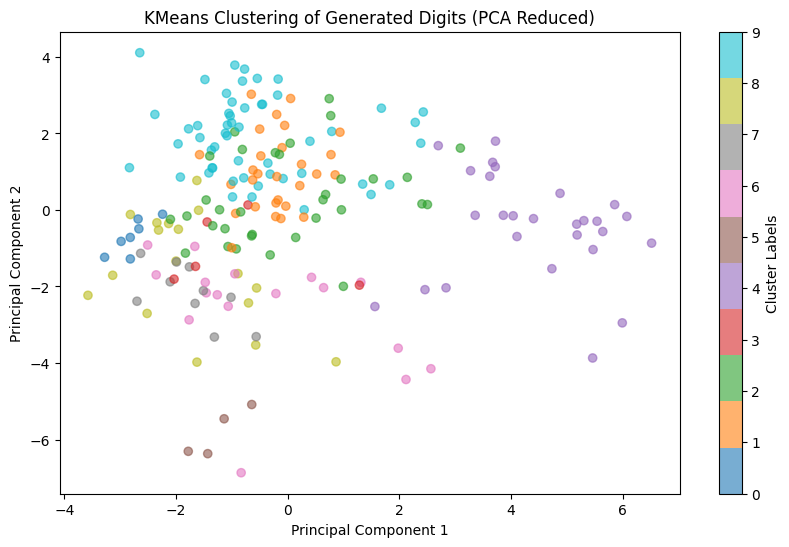

Clustering Purity Score: 0.0700


In [14]:

def perform_clustering(csv_file, n_clusters=10):
    """
    Performs clustering using KMeans and visualizes the clusters in a 2D space after PCA.
    :param csv_file: Path to dataset CSV file
    :param n_clusters: Number of clusters (should match the number of digits: 10)
    """
    df = pd.read_csv(csv_file, header=None)
    
    # Separate features and labels
    X, y = df.iloc[:, :-1], df.iloc[:, -1]
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Reduce dimensions using PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    # Plot PCA clusters
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter, label='Cluster Labels')
    plt.title("KMeans Clustering of Generated Digits (PCA Reduced)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()
    
    # Check clustering quality by comparing with true labels
    cluster_purity = np.mean(cluster_labels == y)
    print(f"Clustering Purity Score: {cluster_purity:.4f}")

if __name__ == "__main__":
    perform_clustering("/Users/HP\Desktop/datascience/Generated_Number_Classification_with_FCNN/source_code/dataset.csv")




<>:81: SyntaxWarning: invalid escape sequence '\D'
<>:82: SyntaxWarning: invalid escape sequence '\D'
<>:81: SyntaxWarning: invalid escape sequence '\D'
<>:82: SyntaxWarning: invalid escape sequence '\D'
C:\Users\HP\AppData\Local\Temp\ipykernel_24012\1278128984.py:81: SyntaxWarning: invalid escape sequence '\D'
  plot_sample_images("/Users/HP\Desktop/datascience/Generated_Number_Classification_with_FCNN/source_code/dataset.csv")
C:\Users\HP\AppData\Local\Temp\ipykernel_24012\1278128984.py:82: SyntaxWarning: invalid escape sequence '\D'
  plot_sample_images("/Users/HP\Desktop/datascience/Generated_Number_Classification_with_FCNN/source_code/dataset.csv")


Missing Values: 0
Invalid Entries (not 0/1): 0
Total Samples: 200
Duplicate Samples: 0
No duplicates found.


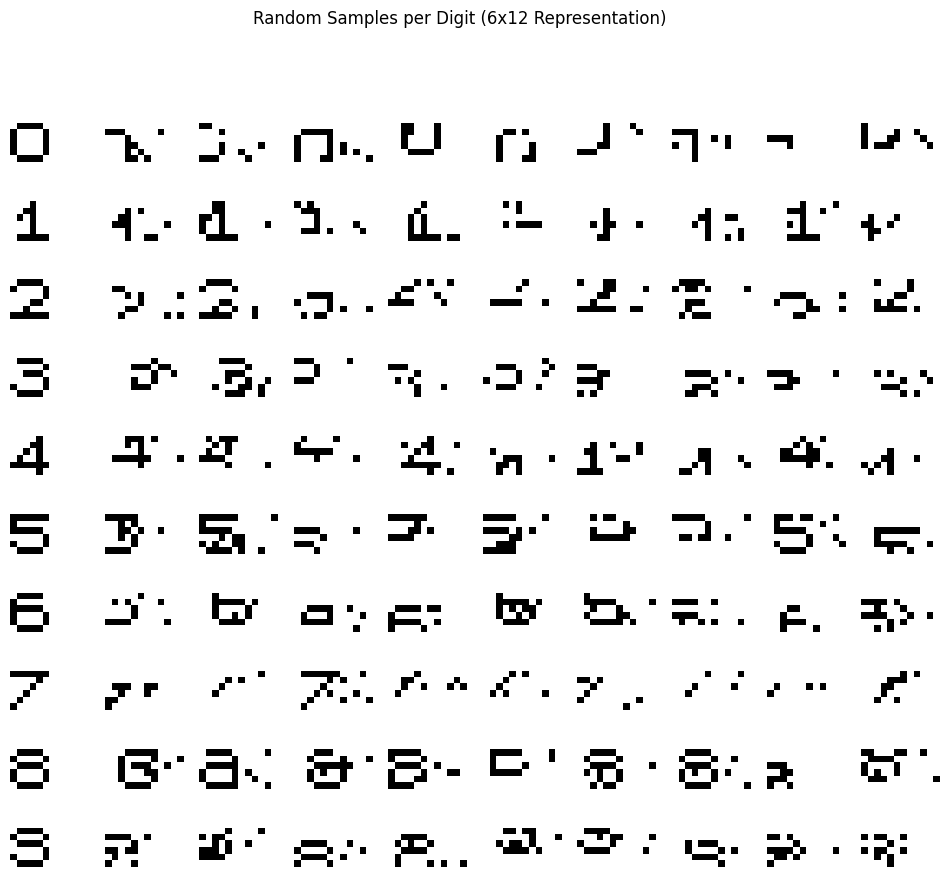

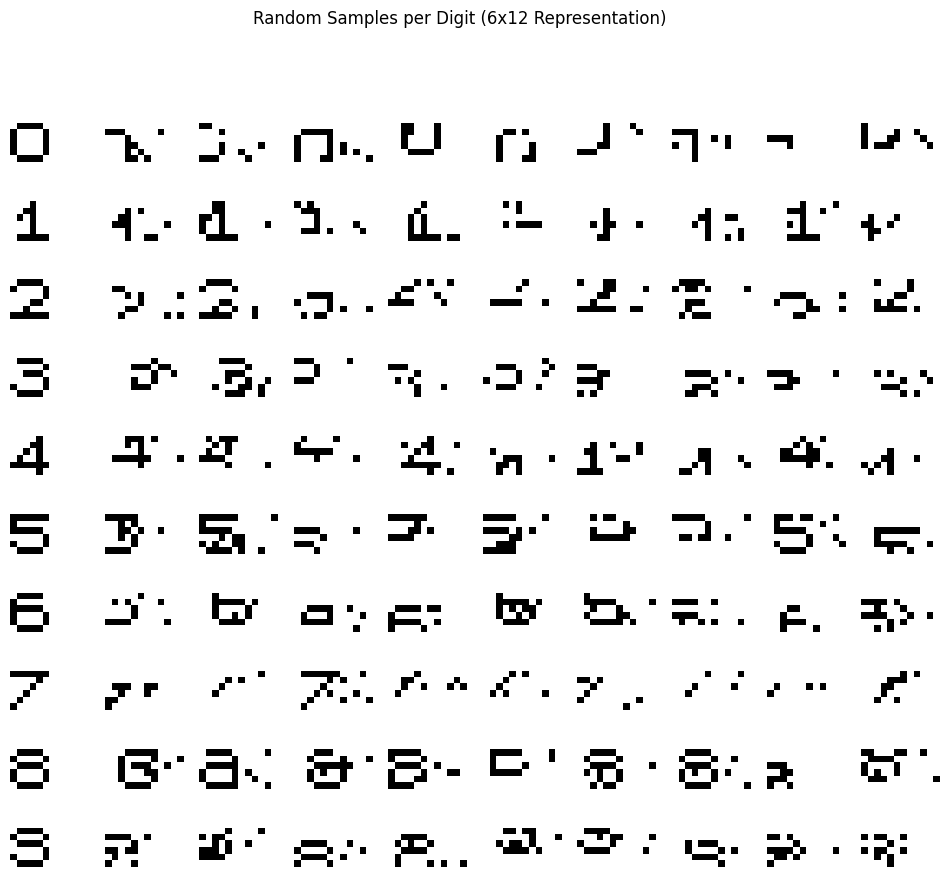

In [17]:


def check_corrupted_samples(csv_file):
    """
    Detects missing values and invalid entries in the dataset.
    :param csv_file: Path to dataset CSV file
    """
    df = pd.read_csv(csv_file, header=None)
    
    # Check for NaN values
    num_missing = df.isnull().sum().sum()

    # Check for invalid values (anything other than 0 or 1 in feature columns)
    feature_columns = df.iloc[:, :-1]  # Exclude label column
    num_invalid = (feature_columns != 0).astype(int) + (feature_columns != 1).astype(int) - 1
    num_invalid = num_invalid.sum().sum()

    print(f"Missing Values: {num_missing}")
    print(f"Invalid Entries (not 0/1): {num_invalid}")

    if num_missing > 0:
        print("Warning: Dataset contains missing values!")
    
    if num_invalid > 0:
        print("Warning: Dataset contains invalid entries!")

if __name__ == "__main__":
    check_corrupted_samples("/Users/HP/Desktop/datascience/Generated_Number_Classification_with_FCNN/source_code/dataset.csv")


import pandas as pd

def check_duplicates(csv_file):
    """
    Checks for duplicate samples in the dataset.
    :param csv_file: Path to dataset CSV file
    """
    df = pd.read_csv(csv_file, header=None)
    
    num_samples = len(df)
    num_duplicates = df.duplicated().sum()

    print(f"Total Samples: {num_samples}")
    print(f"Duplicate Samples: {num_duplicates}")

    if num_duplicates > 0:
        print("Warning: Dataset contains duplicate samples!")
    else:
        print("No duplicates found.")

if __name__ == "__main__":
    check_duplicates("/Users/HP/Desktop/datascience/Generated_Number_Classification_with_FCNN/source_code/dataset.csv")  # Adjust the path as needed



def plot_sample_images(csv_file, num_samples=10):
    """
    Randomly selects and plots a few samples per digit.
    :param csv_file: Path to dataset CSV file
    :param num_samples: Number of samples per digit to visualize
    """
    df = pd.read_csv(csv_file, header=None)
    
    # Separate features and labels
    X, y = df.iloc[:, :-1], df.iloc[:, -1]

    # Create a figure for visualization
    fig, axes = plt.subplots(nrows=10, ncols=num_samples, figsize=(num_samples * 1.2, 10))

    for digit in range(10):
        # Get 'num_samples' random samples of this digit
        digit_samples = X[y == digit].sample(n=min(num_samples, len(X[y == digit])), random_state=42).values
        
        for i in range(len(digit_samples)):
            ax = axes[digit, i]
            ax.imshow(digit_samples[i].reshape(6, 12), cmap="gray_r")
            ax.axis("off")

    plt.suptitle("Random Samples per Digit (6x12 Representation)")
    plt.show()

if __name__ == "__main__":
    plot_sample_images("/Users/HP\Desktop/datascience/Generated_Number_Classification_with_FCNN/source_code/dataset.csv")
    plot_sample_images("/Users/HP\Desktop/datascience/Generated_Number_Classification_with_FCNN/source_code/dataset.csv")


def plot_class_distribution(df):
    """
    Plots the class distribution of a dataset.
    :param df: Pandas DataFrame containing the dataset
    """
    label_counts = df.iloc[:, -1].value_counts().sort_index()

    plt.figure(figsize=(8, 5))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette="magma")
    plt.xlabel("Digit Label")
    plt.ylabel("Count")
    plt.title("Class Distribution")
    plt.xticks(rotation=0)
    plt.show()

def load_and_describe(csv_file):
    """
    Loads dataset and prints basic statistics.
    :param csv_file: Path to dataset CSV file
    :return: DataFrame
    """
    df = pd.read_csv(csv_file, header=None)
    print("Dataset Overview:")
    print(df.describe())
    return df


In [19]:


# Load training history
history = torch.load("training_history.pth")

epochs = range(1, len(history["loss"]) + 1)

# Plot loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history["loss"], label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history["accuracy"], label="Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'training_history.pth'

In [24]:


# Load dataset
df = pd.read_csv("Users/HP/Desktop/datascience/Generated_Number_Classification_with_FCNN/source_code/dataset.csv")
X y = df.iloc[:, :-1].values, df.iloc[:, -1].values

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)

# Load trained model
model = FCNN()
model.load_state_dict(torch.load("fcnn_model.pth"))
model.eval()

# Predict
with torch.no_grad():
    y_pred = model(X)
    y_pred = torch.argmax(y_pred, axis=1).numpy()

# Compute confusion matrix
cm = confusion_matrix(y, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


SyntaxError: invalid syntax (3197941244.py, line 3)

In [ ]:


# Load dataset
df = pd.read_csv("Users/HP/Desktop/datascience/Generated_Number_Classification_with_FCNN/source_code/dataset.csv", header=None)
X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values  # Features and labels

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)

# Load trained model
model = FCNN()
model.load_state_dict(torch.load("../models/fcnn_model.pth"))
model.eval()

# Predict on dataset
with torch.no_grad():
    y_pred = model(X)
    y_pred = torch.argmax(y_pred, axis=1).numpy()

# Classification Report
print("🔍 Classification Report:")
print(classification_report(y, y_pred))


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(72, 20)  # First hidden layer
        self.fc2 = nn.Linear(20, 10)  # Second hidden layer
        self.fc3 = nn.Linear(10, 10)  # Output layer (10 classes)
        self.relu = nn.ReLU()  # Activation function
        self.softmax = nn.Softmax(dim=1)  # Softmax for classification

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x


In [ ]:


# Load dataset
df = pd.read_csv("../data/dataset.csv", header=None)
X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)

# Load trained model
model = FCNN()
model.load_state_dict(torch.load("fcnn_model.pth"))
model.eval()

# Select random samples
indices = np.random.choice(len(X), 5, replace=False)
X_samples, y_true = X[indices], y[indices]

# Predict
with torch.no_grad():
    y_pred = torch.argmax(model(X_samples), axis=1).numpy()

# Plot results
plt.figure(figsize=(10, 5))
for i, (sample, true_label, pred_label) in enumerate(zip(X_samples, y_true, y_pred)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(sample.numpy().reshape(6, 12), cmap="gray", aspect="auto")
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from model import FCNN

# Load dataset
df = pd.read_csv("../data/dataset.csv", header=None)
X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Define model, loss, and optimizer
model = FCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
history = {"loss": [], "accuracy": []}

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    
    loss.backward()
    optimizer.step()
    
    # Calculate accuracy
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y).sum().item() / len(y)
    
    history["loss"].append(loss.item())
    history["accuracy"].append(accuracy)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")

# Save model & training history
torch.save(model.state_dict(), "fcnn_model.pth")
torch.save(history, "training_history.pth")

print("Training complete. Model & history saved.")
